In [1]:
# https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

Model selection is the task of selecting a statistical model from a set of candidate models, given data. In the simplest cases, a pre-existing set of data is considered. Given candidate models of similar predictive or explanatory power, the simplest model is most likely to be the best choice.

The data is available in Google BigQuery that can be downloaded from here. The data is also publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv.

In [2]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
# from bs4 import BeautifulSoup

%matplotlib inline

In [3]:
df_train = pd.read_csv('../input/ndsc-beginner/train.csv')
# df = df[pd.notnull(df['tags'])]
df_train.head(10)

,itemid,title,Category,image_path
0,307504,nyx sex bomb pallete natural palette,0,beauty_image/6b2e9cbb279ac95703348368aa65da09.jpg
1,461203,etude house precious mineral any cushion pearl...,1,beauty_image/20450222d857c9571ba8fa23bdedc8c9.jpg
2,3592295,milani rose powder blush,2,beauty_image/6a5962bed605a3dd6604ca3a4278a4f9.jpg
3,4460167,etude house baby sweet sugar powder,3,beauty_image/56987ae186e8a8e71fcc5a261ca485da.jpg
4,5853995,bedak revlon color stay aqua mineral make up,3,beauty_image/9c6968066ebab57588c2f757a240d8b9.jpg
5,6208490,dr pure whitening cream,4,beauty_image/77e6b7e9d5544adbfda6809b2351c4fa.jpg
6,6959546,chanel powder blush malice,2,beauty_image/485c4b8435a1e94976a569f3f014ea8b.jpg
7,8984461,snail white cream original 100,4,beauty_image/c7336f1c2e590d4c2bee219a6a0351a7.jpg
8,9184082,sunprise all proof spf 50,4,beauty_image/970b32aa659689f371516e5ceb423e25.jpg
9,10345338,eyebrow powder nyx satuan rp 15.000 pc,3,beauty_image/49a47745248031775c98593f70f7201a.jpg


In [4]:
# df['post'].apply(lambda x: len(x.split(' '))).sum()

We have over 10 million words in the data.

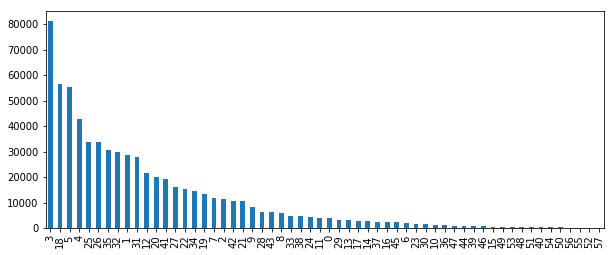

In [5]:
plt.figure(figsize=(10,4))
df_train.Category.value_counts().plot(kind='bar');

The classes are NOT very well balanced.

### BOW with keras

In [6]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


In [7]:
train_posts, test_posts, train_tags, test_tags = train_test_split(df_train['title'], 
                                                                  df_train['Category'], 
                                                                  test_size=0.33, 
                                                                  random_state=42)

In [8]:
from pymagnitude import Magnitude
from pymagnitude import MagnitudeUtils

MAX_WORDS = 100 # The maximum number of words the sequence model will consider
vectors = Magnitude("../input/quora-insincere-questions-classification/wiki-news-300d-1M.magnitude", 
                   pad_to_length=MAX_WORDS)

In [10]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [11]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [12]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [13]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [14]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (446632, 1000)
x_test shape: (219983, 1000)
y_train shape: (446632, 58)
y_test shape: (219983, 58)


In [15]:
batch_size = 32
epochs = 2

In [16]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 401968 samples, validate on 44664 samples
Epoch 1/2
401968/401968 [==============================] - 254s 633us/step - loss: 1.0740 - acc: 0.6778 - val_loss: 0.9715 - val_acc: 0.6958
Epoch 2/2
401968/401968 [==============================] - 195s 485us/step - loss: 0.9806 - acc: 0.6967 - val_loss: 0.9463 - val_acc: 0.7050


In [18]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

219983/219983 [==============================] - 16s 72us/step
Test accuracy: 0.704872649251524


In [22]:
df_public = pd.read_csv('../input/ndsc-beginner/test.csv')
df_public.head(10)
x_train = tokenize.texts_to_matrix(df_public["title"])

,itemid,title,image_path
0,370855998,flormar 7 white cream bb spf 30 40ml,beauty_image/1588591395c5a254bab84042005f2a9f.jpg
1,637234604,maybelline clear smooth all in one bb cream sp...,beauty_image/920985ed9587ea20f58686ea74e20f93.jpg
2,690282890,murah innisfree eco natural green tea bb cream...,beauty_image/90b40e5710f54352b243fcfb0f5d1d7f.jpg
3,930913462,loreal white perfect day cream spf 17 pa white...,beauty_image/289c668ef3d70e1d929d602d52d5d78a.jpg
4,1039280071,hada labo cc cream ultimate anti aging spf 35 ...,beauty_image/d5b3e652c5822d2306f4560488ec30c6.jpg
5,1327710392,cathy doll cc speed white powder pact spf 40 o...,beauty_image/e1e50828d5594721a7d5d5c1ff78afbd.jpg
6,1328802799,safi white natural brightening cream 45g,beauty_image/97ec852d5afc5d82ac02b80083cf292f.jpg
7,1330468145,light beige 03 bioaqua bb cushion exquisite de...,beauty_image/8ce1a5fe546f0cc795329bad599a8d5a.jpg
8,1677309730,new produk missha m perfect bb cream share in ...,beauty_image/755fcc85c687e8cb53d2a8d43ebfe251.jpg
9,1683142205,ready laneige bb cushion anti aging spf 50 pa,beauty_image/34b56398c099505c650cf2447dc9f21f.jpg


In [23]:
preds = model.predict(x_train)

In [25]:
print(preds)

[[6.1294209e-04 5.4898545e-02 2.7833486e-05 ... 4.7541674e-13
  1.1826076e-12 6.4319489e-16]
 [5.7738220e-05 2.4714779e-02 1.2187214e-06 ... 1.4054010e-22
  1.6041333e-19 6.5452178e-26]
 [3.7365645e-04 1.1875384e-02 9.7932774e-05 ... 1.3371488e-18
  1.1737988e-17 5.7025587e-24]
 ...
 [1.4403653e-04 2.5047601e-04 1.3550653e-05 ... 5.8024001e-05
  7.2276086e-04 5.2496389e-04]
 [4.9954933e-11 6.8471948e-09 4.6899058e-11 ... 6.0791555e-10
  5.6631140e-09 4.7648333e-11]
 [1.4220194e-07 1.3241091e-06 2.3517119e-08 ... 2.4842811e-05
  1.3471855e-04 2.1749327e-06]]


In [26]:
df_public['Category'] = [np.argmax(pred) + 1 for pred in preds]
df_submit = df_public[['itemid', 'Category']].copy()
df_submit.to_csv('submission.csv', index=False)